In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
import warnings
warnings.filterwarnings('ignore')

In [152]:
# from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pyclustertend import hopkins
from scipy.stats import shapiro

In [153]:
from sklearn.ensemble import IsolationForest
from pyod.models.mcd import MCD

In [154]:
def outlier_KMeans(data,contamination=0.05,clustering=True):
    data = np.array(data)
    data_dimension = data.ndim
    if data_dimension == 1:
        # Single Dimensional Data
        if anderson(data).statistic < anderson(data).critical_values[2]:
            # data_distribution = 'normal'
            sc = StandardScaler()
            x_sc = sc.fit_transform(data.reshape(-1,1))
            
            if clustering == False:
                outliers = x_sc[(x_sc > 3) | (x_sc < -3)]
                labels = np.ones(len(data))
                outlier_mask = np.isin(data, outliers)
                labels[outlier_mask] = -1
                return labels
            else:
                filtered_data = x_sc[(-3 <= x_sc) & (x_sc <= 3)]
                hopkins_stats = hopkins(filtered_data,len(filtered_data)//10)
                if hopkins_stats < 0.1:
                    return ('Data can not be clustered')
                else:
                    k_values = range(2, 11)
                    models = [KMeans(n_clusters=k, random_state=42,n_init='auto').fit(filtered_data.reshape(-1,1)) for k in k_values]
                    labels = [model.labels_ for model in models]
                    sil_score = [silhouette_score(filtered_data,label) for label in labels]
                    optimal_k = k_values[np.argmax(sil_score)]
                    
                    model = KMeans(n_clusters=optimal_k,random_state=0,n_init='auto')
                    model.fit(filtered_data.reshape(-1,1))
                    labels = model.labels_
                    cluster_label = -1 * np.ones_like(x_sc.flatten())
                    cluster_label[np.unique(np.where((-3 <= x_sc) & (x_sc <= 3))[0])] = labels
                    return cluster_label
        
        else:
            # data_distribution = 'non_normal'
            Q1 = np.quantile(data,0.25)
            Q3 = np.quantile(data,0.75)
            IQR = Q3-Q1
            lw = Q1 - 1.5*IQR
            rw = Q3 + 1.5*IQR
            
            if clustering == False:
                outliers = data[(data > rw) | (data < lw)]
                labels = np.ones(len(data))
                outlier_mask = np.isin(data, outliers)
                labels[outlier_mask] = -1
                return labels
            else:
                filtered_data = data[(lw <= data) & (data <= rw)]
                hopkins_stats = hopkins(filtered_data,len(filtered_data)//10)
                if hopkins_stats < 0.1:
                    return ('Data can not be clustered')
                else:
                    k_values = range(2, 11)
                    models = [KMeans(n_clusters=k, random_state=42,n_init='auto').fit(filtered_data.reshape(-1,1)) for k in k_values]
                    labels = [model.labels_ for model in models]
                    sil_score = [silhouette_score(filtered_data,label) for label in labels]
                    optimal_k = k_values[np.argmax(sil_score)]
                    
                    model = KMeans(n_clusters=optimal_k,random_state=0,n_init='auto')
                    model.fit(filtered_data.reshape(-1,1))
                    labels = model.labels_
                    cluster_label = -1 * np.ones_like(x_sc.flatten())
                    cluster_label[np.unique(np.where((-3 <= x_sc) & (x_sc <= 3))[0])] = labels
                    return cluster_label
    else:
        # Multi Dimensional Data
        if shapiro(data)[1] < 0.05:
            #data_distribution = 'non_normal'
            df = pd.DataFrame(data)
            model = IsolationForest(contamination=contamination)
            df['anomaly'] = model.fit_predict(df)
            
            if clustering == False:
                return np.array(df['anomaly'])
            else:
                fil = df['anomaly'] == 1
                filtered_data = df.loc[fil].iloc[:,:-1].values
                hopkins_stats = hopkins(filtered_data,len(filtered_data)//10)
                print(hopkins_stats)
                if hopkins_stats < 0.1:
                    return ('Data can not be clustered')
                else:
                    k_values = range(2, 11)
                    models = [KMeans(n_clusters=k, random_state=42,n_init='auto').fit(filtered_data) for k in k_values]
                    labels = [model.labels_ for model in models]
                    sil_score = [silhouette_score(filtered_data,label) for label in labels]
                    optimal_k = k_values[np.argmax(sil_score)]
                    
                    model = KMeans(n_clusters=optimal_k,random_state=42,n_init='auto')
                    model.fit(filtered_data)
                    labels = model.labels_
                    df.loc[df['anomaly'] == -1,'label'] = -1
                    df.loc[df['anomaly'] == 1,'label'] = labels
                    return np.array(df['label'])
                
        else:
            # data_distribution = 'normal'
            df = pd.DataFrame(data)
            model = MCD(contamination=contamination)
            model.fit(data)
            df['anomaly'] = model.predict(data)
            df['anomaly'] = df['anomaly'].replace({0: 1, 1: -1})

            if clustering == False:
                return np.array(df['anomaly'])
            else:
                fil = df['anomaly'] == 1
                filtered_data = df.loc[fil].iloc[:,:-1].values
                hopkins_stats = hopkins(filtered_data,len(filtered_data)//10)
                print(hopkins_stats)
                if hopkins_stats < 0.1:
                    return ('Data can not be clustered')
                else:
                    k_values = range(2, 11)
                    models = [KMeans(n_clusters=k, random_state=42,n_init='auto').fit(filtered_data) for k in k_values]
                    labels = [model.labels_ for model in models]
                    sil_score = [silhouette_score(filtered_data,label) for label in labels]
                    optimal_k = k_values[np.argmax(sil_score)]
                    
                    model = KMeans(n_clusters=optimal_k,random_state=42,n_init='auto')
                    model.fit(filtered_data)
                    labels = model.labels_
                    df.loc[df['anomaly'] == -1,'label'] = -1
                    df.loc[df['anomaly'] == 1,'label'] = labels
                    return np.array(df['label'])

### Dataset 1 

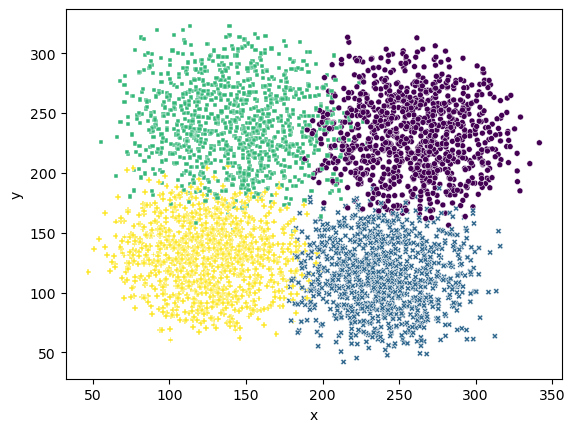

In [155]:
df = pd.read_csv('../2D Clustering Datasets/blob.csv')
sns.scatterplot(x=df['x'],y=df['y'],style=df['color'],hue=df['color'],palette='viridis',size=1,legend=False)
plt.show()

In [156]:
model = KMeans(n_clusters=4,random_state=0,n_init='auto')
model.fit(df.iloc[:,:-1])

KMeans(n_clusters=4, n_init='auto', random_state=0)

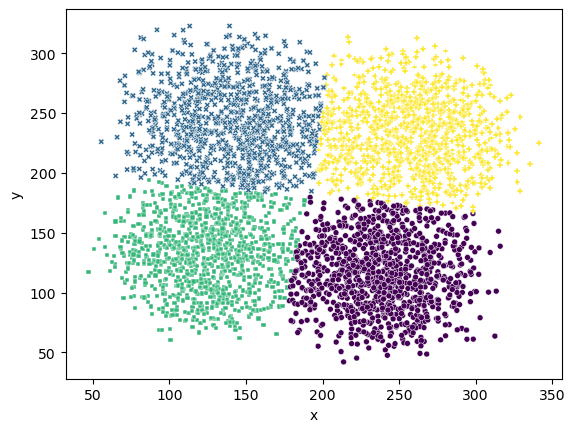

In [157]:
labels = model.labels_
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

0.3339452302208393


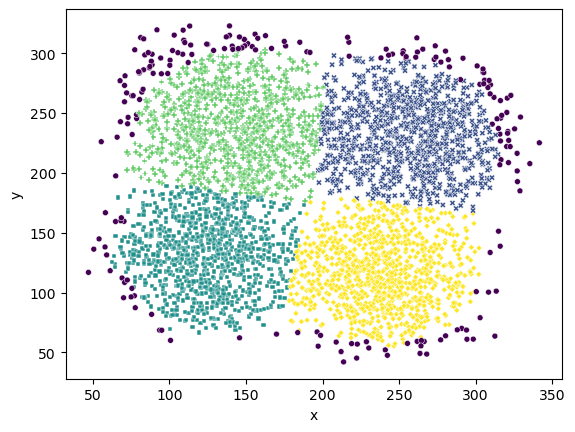

In [158]:
labels = outlier_KMeans(df.iloc[:,:-1])
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

### Dataset 2

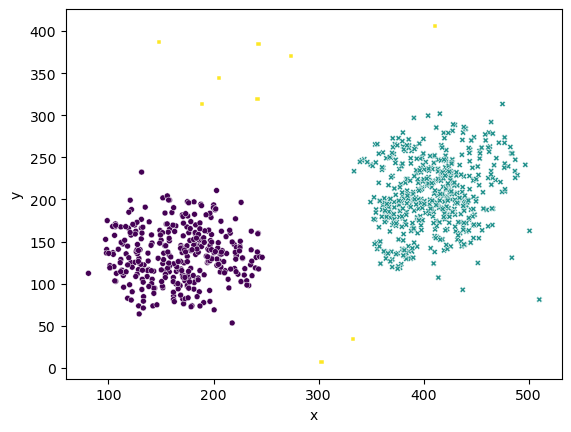

In [159]:
df = pd.read_csv('../2D Clustering Datasets/outliers.csv')
sns.scatterplot(x=df['x'],y=df['y'],style=df['color'],hue=df['color'],palette='viridis',size=1,legend=False)
plt.show()

In [160]:
model = KMeans(n_clusters=2,random_state=0,n_init='auto')
model.fit(df.iloc[:,:-1])

KMeans(n_clusters=2, n_init='auto', random_state=0)

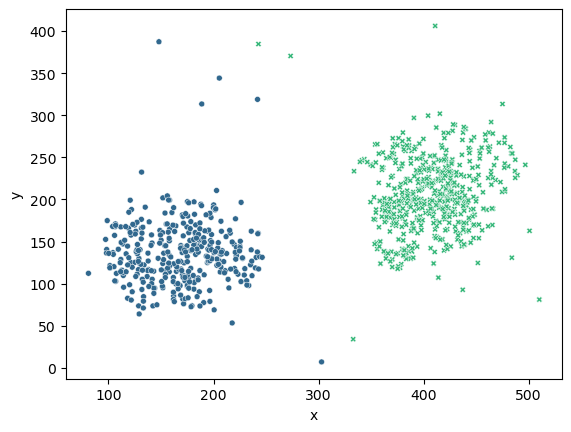

In [161]:
labels = model.labels_
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

0.13224298497661777


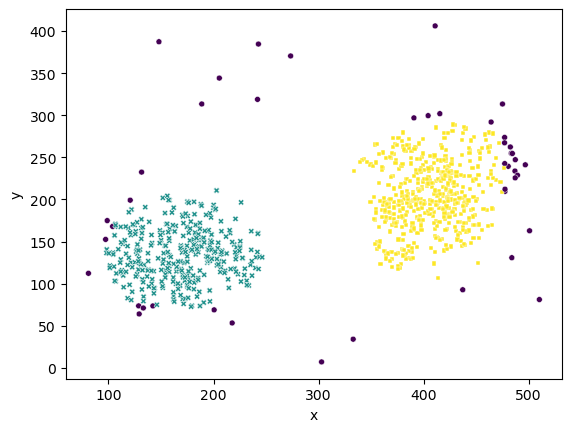

In [162]:
labels = outlier_KMeans(df.iloc[:,:-1])
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

### Dataset 3

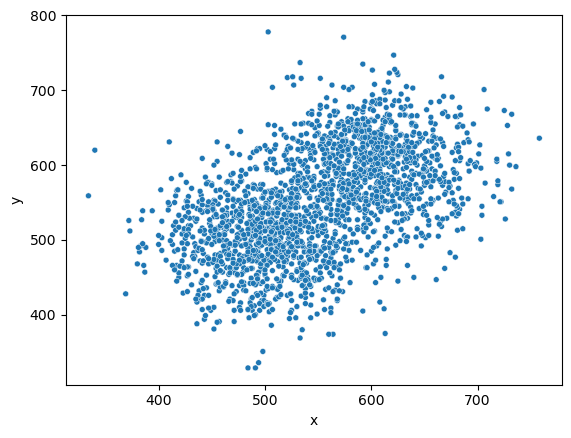

In [163]:
df = pd.read_csv('../2D Clustering Datasets/g2-2-50.txt',sep='     ',header=None)
df.columns = ['x', 'y']
sns.scatterplot(x=df['x'],y=df['y'],size=1,legend=False)
plt.show()

In [164]:
model = KMeans(n_clusters=2,random_state=0,n_init='auto')
model.fit(df.iloc[:,:-1])

KMeans(n_clusters=2, n_init='auto', random_state=0)

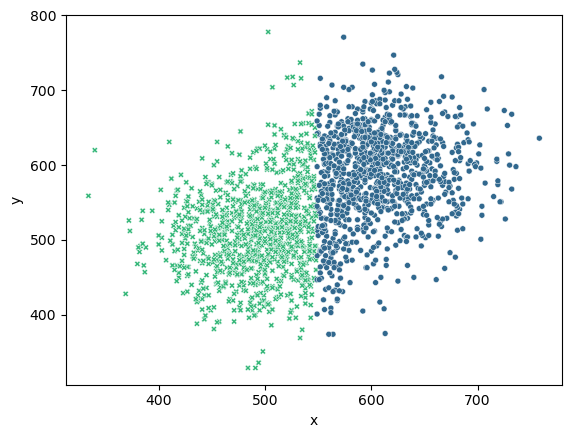

In [165]:
labels = model.labels_
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

0.1916542457312591


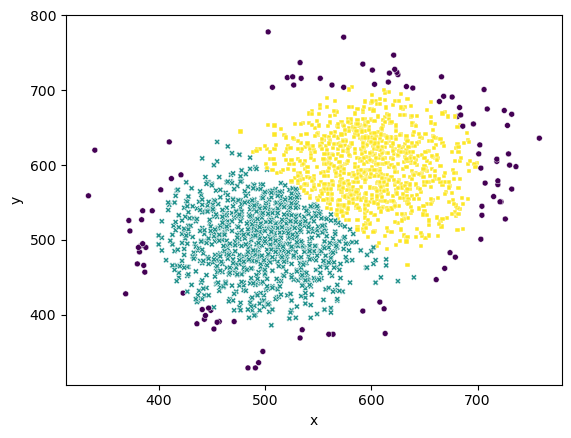

In [166]:
labels = outlier_KMeans(df.iloc[:,:])
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

### Dataset 4

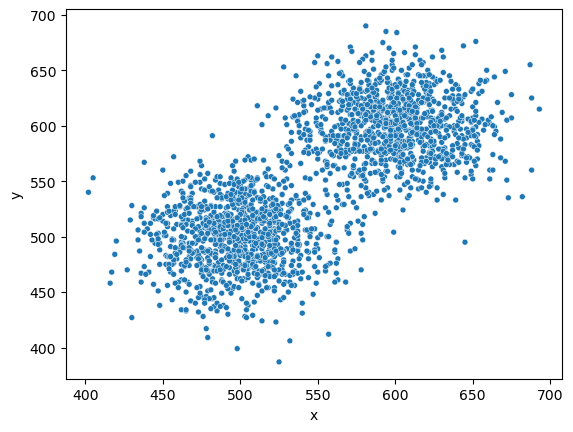

In [167]:
df = pd.read_csv('../2D Clustering Datasets/g2-2-30.txt',sep='     ',header=None)
df.columns = ['x', 'y']
sns.scatterplot(x=df['x'],y=df['y'],size=1,legend=False)
plt.show()

In [168]:
model = KMeans(n_clusters=2,random_state=0,n_init='auto')
model.fit(df.iloc[:,:-1])

KMeans(n_clusters=2, n_init='auto', random_state=0)

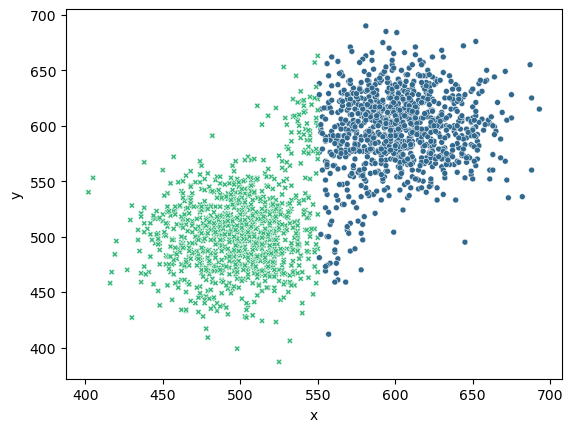

In [169]:
labels = model.labels_
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

0.14458252553687892


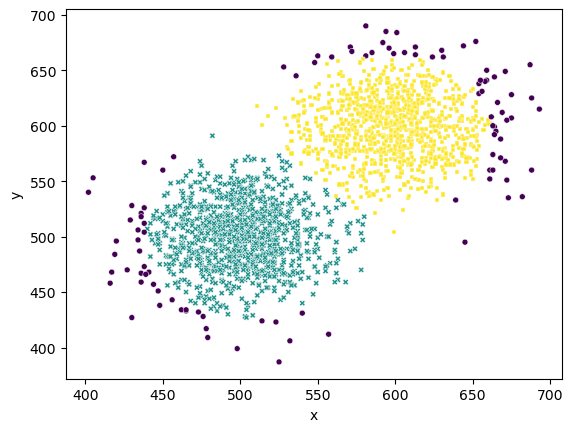

In [170]:
labels = outlier_KMeans(df.iloc[:,:])
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

### Dataset 5

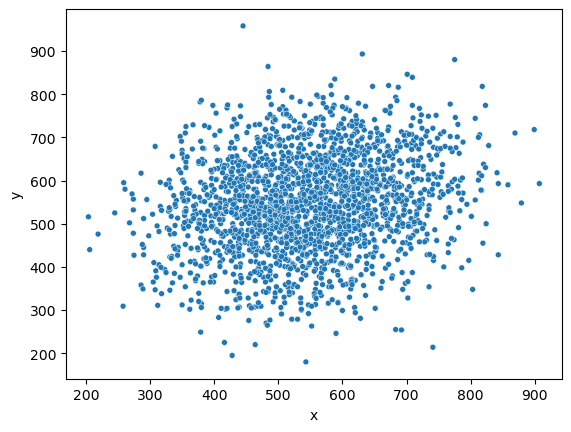

In [171]:
df = pd.read_csv('../2D Clustering Datasets/g2-2-100.txt',sep='     ',header=None)
df.columns = ['x', 'y']
sns.scatterplot(x=df['x'],y=df['y'],size=1,legend=False)
plt.show()

In [174]:
model = KMeans(n_clusters=1,random_state=0,n_init='auto')
model.fit(df.iloc[:,:-1])

KMeans(n_clusters=1, n_init='auto', random_state=0)

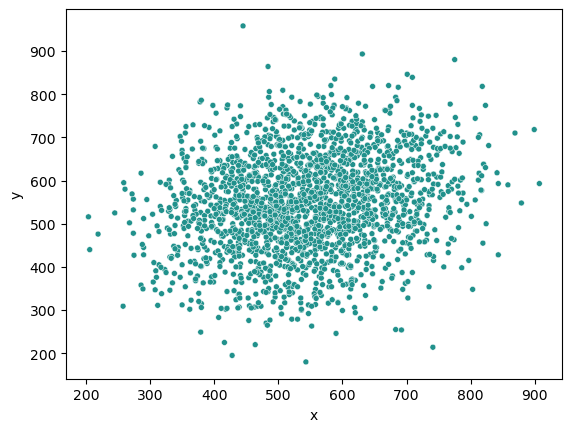

In [175]:
labels = model.labels_
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()

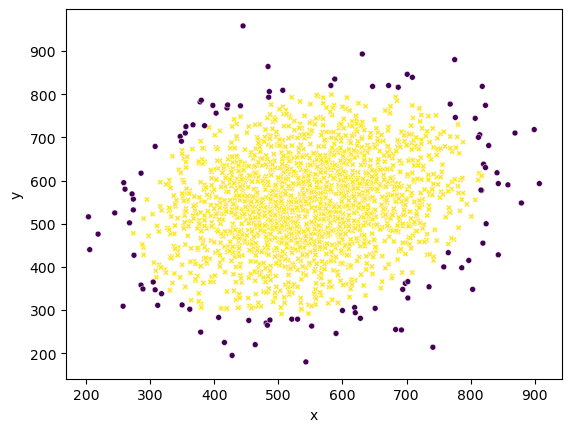

In [176]:
labels = outlier_KMeans(df.iloc[:,:],clustering=False)
sns.scatterplot(x=df['x'],y=df['y'],style=labels,hue=labels,palette='viridis',size=1,legend=False)
plt.show()